In [581]:
#Importar librerias
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA

In [471]:
#Metricas de pronosticos
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_log_error
def calculate_smape(y_true, y_pred):
    """Calculate Symmetric Mean Absolute Percentage Error (SMAPE)."""
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

In [472]:
#Funciones para el codigo
#Obtencion de datos
def obtener_datos(simbolo, periodo, intervalo):
    stock = yf.Ticker(simbolo)
    data = stock.history(period=periodo, interval=intervalo)
    return data['Close']

#Polinomio para la Regresión Lineal 
def calcular_tendencia_polinomio(data):
    y = np.polyfit(range(len(data)), data, 1)
    return np.poly1d(y)

#Funcion general para graficar series temporales 
def plotting_data(data, mostrar_regresion=False):
    fig = px.line(
        x=data.index,  
        y=data.values,  
        labels={
            'x': 'Tiempo', 
            'y': 'Precio'
        }
    )
    
    fig.update_traces(line=dict(color='blue'))
    
    fig.update_layout(
        xaxis=dict(showgrid=True, gridcolor='LightGray'),  
        yaxis=dict(showgrid=True, gridcolor='LightGray'),  
    )

    if mostrar_regresion:
        tendencia = calcular_tendencia_polinomio(data.values)
        x = np.arange(len(data))
        regression_line = tendencia(x)
        fig.add_scatter(x=data.index, y=regression_line, mode='lines', name='RL', line=dict(color='red'))

    fig.update_layout(
        template='simple_white',
        font=dict(size=18),
        title_text='Serie Temporal' + (' con Regresión Lineal' if mostrar_regresion else ''),
        width=650,
        height=400,
        title_x=0.5
    )

    fig.show()

#Prueba de Dicky Fuller
def adf_test(data):
    test_results = adfuller(data)
    print('ADF Staistics:', test_results[0])
    print('P-value:', test_results[1])
    print('Critical Values')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

#Funcion General para graficar pronosticos
def plot_forecast(forecast, title):
    fig  = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train, name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test, name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecast, name='Forecast', mode='lines'))

    fig.update_layout(
        xaxis=dict(showgrid=True, gridcolor='LightGray'),  
        yaxis=dict(showgrid=True, gridcolor='LightGray'),  
    )

    fig.update_layout(
        template='simple_white', 
        font=dict(size=18),
        title_text=title,
        width=650,
        title_x=0.5,
        height=400,
        xaxis_title='Date',
        yaxis_title='Price'
        )
    return fig.show()

#Funcion para graficar la distribucion de residuos
def hist_residuals(train):
    fig = px.histogram(train, nbins=30)  # Ajusta nbins si es necesario
    fig.update_layout(
        template='simple_white',
        font=dict(size=18),
        title_text='Distribución de Residuales',
        width=700, 
        title_x=0.5, 
        height=400, 
        xaxis_title='Residuos', 
        yaxis_title='Conteo'
    )
    fig.show()
#Function to plot the cross validation of various sklearn splitter objects.

def plot_cross_val(n_splits: int,
                   splitter_func,
                   df: pd.DataFrame,
                   title_text: str) -> None:
    split = 1
    plot_data = []

    for train_index, valid_index in splitter_func(n_splits=n_splits).split(df):
        plot_data.append([train_index, 'Train', f'{split}'])
        plot_data.append([valid_index, 'Test', f'{split}'])
        split += 1

    plot_df = pd.DataFrame(plot_data,
                           columns=['Index', 'Dataset', 'Split'])\
                           .explode('Index')

    fig = go.Figure()
    for _, group in plot_df.groupby('Split'):
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Train'],
                                 y=group['Split'].loc[group['Dataset'] == 'Train'],
                                 name='Train',
                                 line=dict(color="blue", width=10)
                                 ))
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Test'],
                                 y=group['Split'].loc[group['Dataset'] == 'Test'],
                                 name='Test',
                                 line=dict(color="goldenrod", width=10)
                                 ))

    fig.update_layout(template="simple_white", font=dict(size=20),
                      title_text=title_text, title_x=0.5, width=850,
                      height=450, xaxis_title='Index', yaxis_title='Split')

    legend_names = set()
    fig.for_each_trace(
        lambda trace:
        trace.update(showlegend=False)
        if (trace.name in legend_names) else legend_names.add(trace.name))

    return fig.show()

#Cross validacion de hiper parametros en un modelo de holt winter
def hyperparameter_tuning_season_cv(n_splits: int,
                                    gammas: list[float],
                                    df: pd.DataFrame) -> pd.DataFrame:                                   

    tscv = TimeSeriesSplit(n_splits=n_splits)
    error_list = []

    for gamma in gammas:
    
        errors = []
        
        for train_index, valid_index in tscv.split(df):
            train, valid = df.iloc[train_index], df.iloc[valid_index]
            
            model = ExponentialSmoothing(train['data'], trend='mul',
                                         seasonal='mul', seasonal_periods=12) \
                .fit(smoothing_seasonal=gamma)
                
            forecasts = model.forecast(len(valid))
            errors.append(mean_absolute_percentage_error(valid['data'], forecasts))

        error_list.append([gamma, sum(errors) / len(errors)])

    return pd.DataFrame(error_list, columns=['Gamma', 'MAPE'])
    
#Graficar el error de distintos hiperparametros
def plot_error_cv(df: pd.DataFrame,
                  title: str) -> None:                  
    """Bar chart to plot the errors from the different
    hyperparameters."""

    fig = px.bar(df, x='Gamma', y='MAPE')
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=800, title_x=0.5, height=400)

    return fig.show()
    

### Principles.

In [473]:
apple_data = obtener_datos('AAPL', '5y','1d')

In [474]:
apple_data

Date
2019-09-24 00:00:00-04:00     52.659195
2019-09-25 00:00:00-04:00     53.469585
2019-09-26 00:00:00-04:00     53.193810
2019-09-27 00:00:00-04:00     52.934967
2019-09-30 00:00:00-04:00     54.180801
                                ...    
2024-09-17 00:00:00-04:00    216.789993
2024-09-18 00:00:00-04:00    220.690002
2024-09-19 00:00:00-04:00    228.869995
2024-09-20 00:00:00-04:00    228.199997
2024-09-23 00:00:00-04:00    226.470001
Name: Close, Length: 1258, dtype: float64

In [475]:
plotting_data(apple_data)

In [476]:
#Regresión Lineal
def calcular_tendencia_polinomio(data):
    y = np.polyfit(range(len(data)), data, 1)
    return np.poly1d(y)

In [477]:
tendencia_lineal = calcular_tendencia_polinomio(apple_data)

In [478]:
tendencia_lineal

poly1d([ 0.10600302, 76.36890748])

In [479]:
plotting_data(apple_data, True)

In [480]:
#Estacionalidad
#Como podemos revisar por el aumento del precio de la accion, la serie del tiempo
#no se presta a un analisis estacional por el exponencial aumento de los precios, 
# por lo que debemos de transformar la serie para visualizar mas claramente 
# sus patrones.

#Podemos realizar 2 tipos de transformaciones(Diferencial y logaritmica)

#Diferencial
apple_data_diff = apple_data.diff().dropna() #periods=n
plotting_data(apple_data_diff)

#Logaritmica
apple_data_log = np.log(apple_data)
plotting_data(apple_data_log,True)

In [481]:
#Tambien podemos realizar una prueba estadistica como
#la prueba de dicky fuller
adf_test(apple_data_log[1:])

#Los resultados de esta prueba podemos decir con un 84% 
#de confianza que esta serie/datos son estacionarios.


ADF Staistics: -2.314627592828261
P-value: 0.1672936725307359
Critical Values
	1%: -3.44
	5%: -2.86
	10%: -2.57


In [482]:
apple_data_1yr = obtener_datos('AAPL', '1y','1d')
apple_data_1yr

Date
2023-09-25 00:00:00-04:00    175.183594
2023-09-26 00:00:00-04:00    171.084564
2023-09-27 00:00:00-04:00    169.562332
2023-09-28 00:00:00-04:00    169.821014
2023-09-29 00:00:00-04:00    170.338364
                                ...    
2024-09-17 00:00:00-04:00    216.789993
2024-09-18 00:00:00-04:00    220.690002
2024-09-19 00:00:00-04:00    228.869995
2024-09-20 00:00:00-04:00    228.199997
2024-09-23 00:00:00-04:00    226.470001
Name: Close, Length: 251, dtype: float64

In [483]:
#En este caso queremos hacer nuestros datos AUN MAS estacionarios, por lo que usaremos
#la transformacion box-cox para convertir nuestros datos a una distribucion normal
#leible para nuestro modelo.

apple_data_boxcox, lam = boxcox(apple_data_1yr)

apple_data_boxcox, lam

(array([0.34555372, 0.34555371, 0.34555371, 0.34555371, 0.34555371,
        0.34555372, 0.34555371, 0.34555372, 0.34555372, 0.34555372,
        0.34555373, 0.34555372, 0.34555373, 0.34555373, 0.34555373,
        0.34555372, 0.34555372, 0.34555372, 0.34555372, 0.34555371,
        0.34555371, 0.34555372, 0.34555371, 0.3455537 , 0.3455537 ,
        0.34555371, 0.34555371, 0.34555372, 0.34555372, 0.34555372,
        0.34555373, 0.34555373, 0.34555373, 0.34555373, 0.34555374,
        0.34555373, 0.34555374, 0.34555374, 0.34555374, 0.34555374,
        0.34555374, 0.34555374, 0.34555374, 0.34555374, 0.34555374,
        0.34555374, 0.34555374, 0.34555374, 0.34555374, 0.34555374,
        0.34555375, 0.34555375, 0.34555375, 0.34555375, 0.34555375,
        0.34555375, 0.34555375, 0.34555375, 0.34555375, 0.34555375,
        0.34555375, 0.34555375, 0.34555375, 0.34555375, 0.34555375,
        0.34555375, 0.34555375, 0.34555375, 0.34555374, 0.34555373,
        0.34555373, 0.34555373, 0.34555374, 0.34

In [484]:
indexed_apple_data_boxcox =  pd.Series(apple_data_boxcox)
indexed_apple_data_boxcox

0      0.345554
1      0.345554
2      0.345554
3      0.345554
4      0.345554
         ...   
246    0.345554
247    0.345554
248    0.345554
249    0.345554
250    0.345554
Length: 251, dtype: float64

In [485]:
plotting_data(indexed_apple_data_boxcox)

In [486]:
adf_test(indexed_apple_data_boxcox[1:])

#En este caso la transformacion boxcox no fue efectiva para reducir la varianza de nuestros
#Yo recomendaria, hacer un analisis de por que esta transformacion no funciona. Buscar
#nuevas transformaciones. O otros metodos cuantitativos para analizar patrones.

#Mientras tanto, seguiremos explorando el analisis con la serie apple_data_log que tiene
#un 84% de confianza


ADF Staistics: -1.0537088488608568
P-value: 0.7331750667657851
Critical Values
	1%: -3.46
	5%: -2.87
	10%: -2.57


In [487]:
#Serie seleccionada para analisis mas profundo
apple_data_log

Date
2019-09-24 00:00:00-04:00    3.963841
2019-09-25 00:00:00-04:00    3.979113
2019-09-26 00:00:00-04:00    3.973942
2019-09-27 00:00:00-04:00    3.969064
2019-09-30 00:00:00-04:00    3.992327
                               ...   
2024-09-17 00:00:00-04:00    5.378929
2024-09-18 00:00:00-04:00    5.396759
2024-09-19 00:00:00-04:00    5.433154
2024-09-20 00:00:00-04:00    5.430222
2024-09-23 00:00:00-04:00    5.422612
Name: Close, Length: 1258, dtype: float64

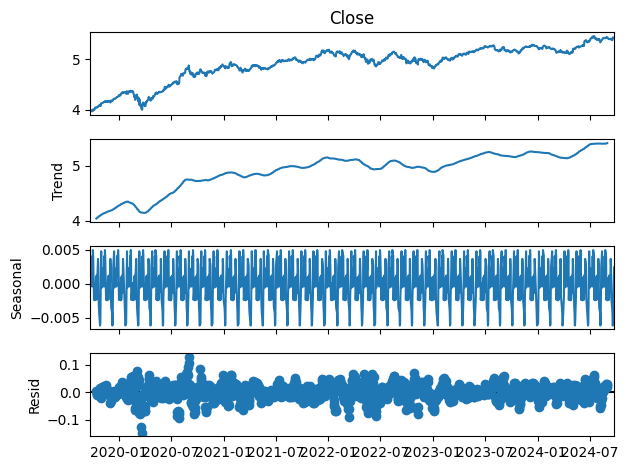

In [488]:
#Descomposicion de series de tiempo.
dscpst_apple_data = seasonal_decompose(apple_data_log, model='additive',period=30)

dscpst_apple_data.plot()
plt.show()

In [489]:
dscpst_apple_data

In [490]:
trend = dscpst_apple_data.trend.dropna()
stationary = dscpst_apple_data.seasonal.dropna()
residual = dscpst_apple_data.resid.dropna()
print('trend:',trend,'stationary;', stationary,'residual:', residual)

trend: Date
2019-10-15 00:00:00-04:00    4.038667
2019-10-16 00:00:00-04:00    4.043972
2019-10-17 00:00:00-04:00    4.049306
2019-10-18 00:00:00-04:00    4.055045
2019-10-21 00:00:00-04:00    4.060654
                               ...   
2024-08-26 00:00:00-04:00    5.401232
2024-08-27 00:00:00-04:00    5.402907
2024-08-28 00:00:00-04:00    5.405443
2024-08-29 00:00:00-04:00    5.408055
2024-08-30 00:00:00-04:00    5.409988
Name: trend, Length: 1228, dtype: float64 stationary; Date
2019-09-24 00:00:00-04:00    0.002282
2019-09-25 00:00:00-04:00    0.000363
2019-09-26 00:00:00-04:00    0.001944
2019-09-27 00:00:00-04:00    0.000316
2019-09-30 00:00:00-04:00   -0.000409
                               ...   
2024-09-17 00:00:00-04:00   -0.004268
2024-09-18 00:00:00-04:00   -0.006151
2024-09-19 00:00:00-04:00   -0.005897
2024-09-20 00:00:00-04:00   -0.001908
2024-09-23 00:00:00-04:00    0.002434
Name: seasonal, Length: 1258, dtype: float64 residual: Date
2019-10-15 00:00:00-04:00    0.00

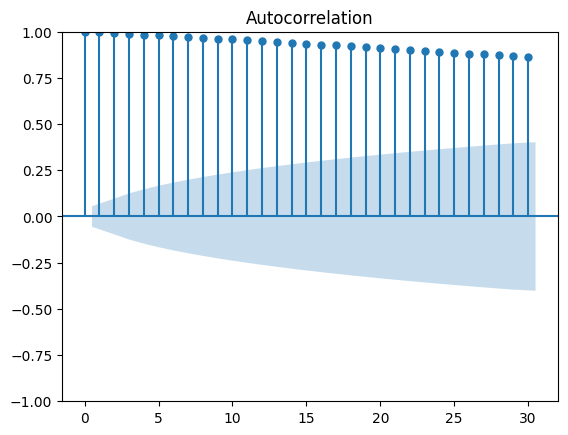

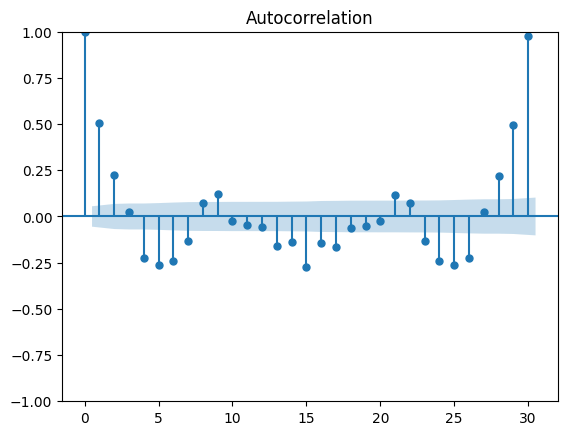

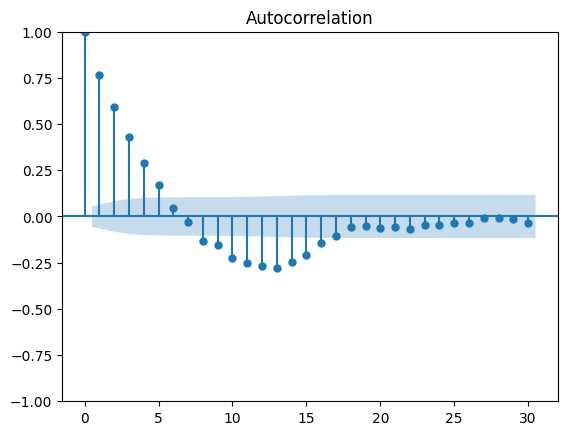

In [491]:
acr_t=plot_acf(trend, lags=30)
acr_s=plot_acf(stationary,lags=30)
acr_r=plot_acf(residual,lags=30)
plt.show()

#Se revisaron graficas de 30,60 y 240. Lags, siendo la de 30 las que tuvieron un ratio
#de signicancia, mas significativas.

#Recordemos la zona azul es el intervalo de 95% de confianza. Afuera signica que la autocorelacion
#fue exitosamente signifativa.

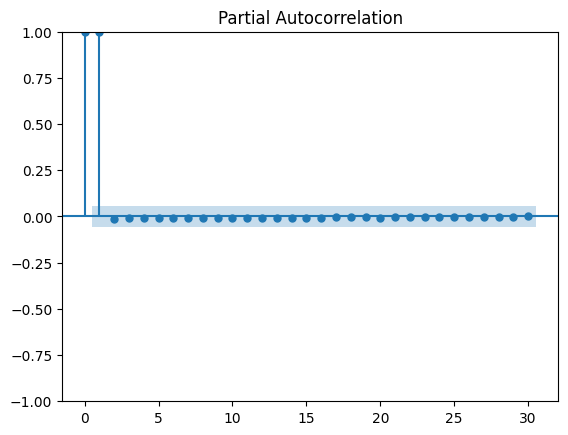

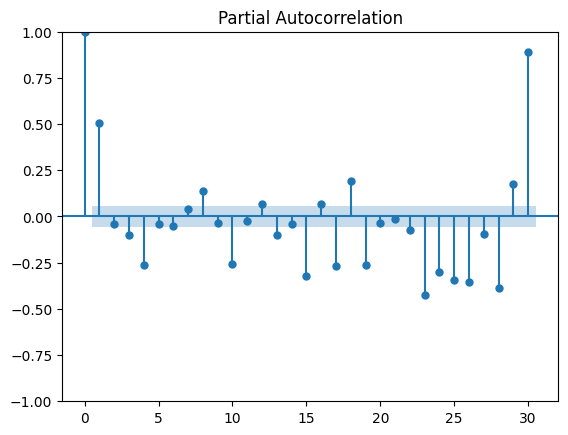

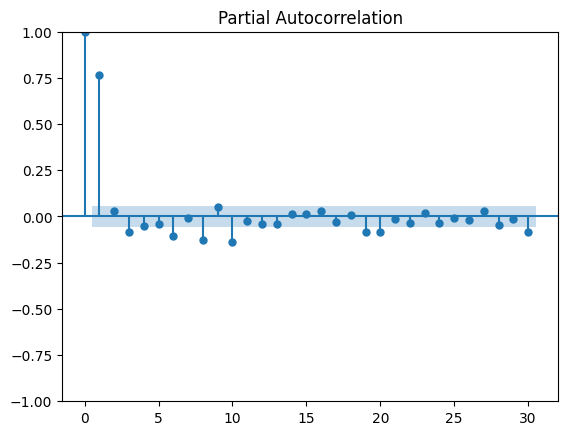

In [492]:
#Autocorrelacion en dos distintos estados de tiempo(autocorrelacion parcial)
pacr_t=plot_pacf(trend,lags=30,method='ywm')
pacr_s=plot_pacf(stationary,lags=30,method='ywm')
pacr_r=plot_pacf(residual,lags=30,method='ywm') #method='ols' for multivariable regressions
plt.show()


### Metrics.

### 4 Basic Forecasting Methods for time analysis.

In [493]:
#Divide data into train/test.
train = apple_data_log.iloc[:-int(len(apple_data_log)*0.2)]
test = apple_data_log.iloc[-int(len(apple_data_log)*0.2):]

In [494]:
#Average Forecast
mean_forecast = train.mean()
mean_forecast_series = pd.Series([mean_forecast] * len(test), index=test.index)
plot_forecast(mean_forecast_series,'Average Forecast')

In [495]:
#Naive Forecasting
naive_forecast = train.iloc[-1]
naive_forecast_series = pd.Series([naive_forecast] * len(test), index=test.index)
plot_forecast(naive_forecast_series,'Average Forecast')

In [496]:
#Seasonal Naive Forecasting
snaive_fc = []

for row_idx in range(len(test)):
    month = test.index[row_idx].month 
    forecast = train[train.index.month == month].iloc[-1]
    snaive_fc.append(forecast)

snaive_fc_series = pd.Series(snaive_fc, index=test.index)
plot_forecast(snaive_fc_series, 'Seasonal Naive Forecast')

In [497]:
#Drift model
constant = (train.iloc[-1] - train.iloc[0])/(len(train)-1)
h = range(len(test))
drift = train.iloc[-1] + h*constant

plot_forecast(drift, 'Drift Forecast')

### Forecasting Models.

In [498]:
#train/test
train = apple_data_log.iloc[:-int(len(apple_data_log)*0.2)]
test = apple_data_log.iloc[-int(len(apple_data_log)*0.2):]

In [499]:
#Simple Exponential Smoothing
model_ses = SimpleExpSmoothing(train).fit(optimized=True)
forecast_ses = model_ses.forecast(len(test))

plot_forecast(forecast_ses, 'Simple Exponential Smoothing')

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [500]:
model_ses.summary()

Dep. Variable:,Close,No. Observations:,1007
Model:,SimpleExpSmoothing,SSE,0.446
Optimized:,True,AIC,-7772.140
Trend:,None,BIC,-7762.310
Seasonal:,None,AICC,-7772.100
Seasonal Periods:,None,Date:,"Tue, 24 Sep 2024"
Box-Cox:,False,Time:,03:24:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8769534,alpha,True
initial_level,3.9638409,l.0,False


In [501]:
#Holts linear trend model
model_holt = Holt(train, damped_trend=True).fit(optimized=True)
forecast_holt = model_holt.forecast(len(test))

plot_forecast(forecast_holt,'Holt')

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [502]:
model_holt.summary()

Dep. Variable:,Close,No. Observations:,1007
Model:,Holt,SSE,0.445
Optimized:,True,AIC,-7767.864
Trend:,Additive,BIC,-7743.290
Seasonal:,None,AICC,-7767.752
Seasonal Periods:,None,Date:,"Tue, 24 Sep 2024"
Box-Cox:,False,Time:,03:24:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8673916,alpha,True
smoothing_trend,0.0077534,beta,True


In [503]:
#Holt Winters Module
model_holt_winters = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=12).fit(optimized=True)

forecast_holt_winters = model_holt_winters.forecast(len(test))

plot_forecast(forecast_holt_winters,'Holt Winters Exponential Smoothing')

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning:

overflow encountered in matmul

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [504]:
model_holt_winters.summary()

Dep. Variable:,Close,No. Observations:,1007
Model:,ExponentialSmoothing,SSE,0.440
Optimized:,True,AIC,-7758.171
Trend:,Multiplicative,BIC,-7679.535
Seasonal:,Multiplicative,AICC,-7757.479
Seasonal Periods:,12,Date:,"Tue, 24 Sep 2024"
Box-Cox:,False,Time:,03:24:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8768808,alpha,True
smoothing_trend,0.000000,beta,True


In [505]:
#Residual analysis
train_fitted_values = model_holt_winters.fittedvalues
train_residuals = model_holt_winters.resid

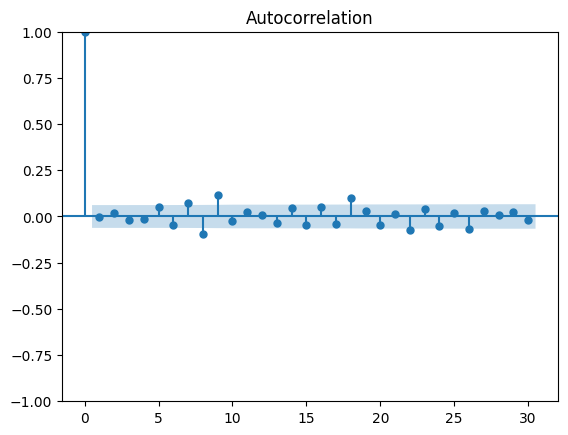

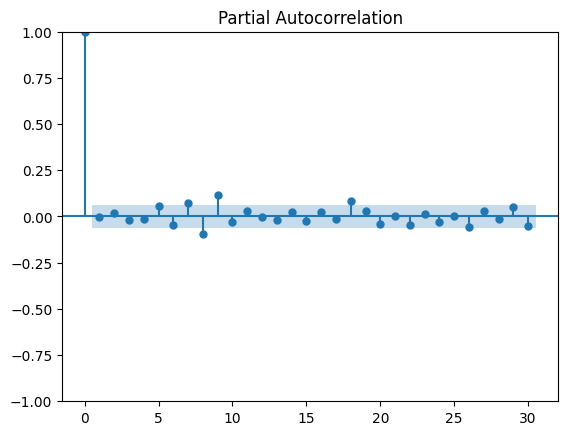

In [506]:
plot_acf(train_residuals, lags=30)
plot_pacf(train_residuals, lags=30)
plt.show()

In [507]:
acorr_ljungbox(train_residuals,return_df=True)

,lb_stat,lb_pvalue
1,0.005641,0.940131
2,0.471100,0.790136
3,0.865522,0.833739
4,1.028523,0.905441
5,3.915993,0.561573
6,6.222155,0.398770
7,11.693884,0.111086
8,21.331354,0.006317
9,35.351014,0.000052
10,36.037778,0.000083


In [508]:
hist_residuals(train_residuals)
print(train_residuals.mean())

0.00012226675622097448


In [509]:
#Cross-validation
plot_cross_val(n_splits=5,
              splitter_func=KFold,
              df=apple_data_log,
              title_text='Cross-Validation')

In [510]:
plot_cross_val(n_splits=5,
               splitter_func=TimeSeriesSplit,
               df=apple_data_log,
               title_text='Time Series Cross-Validation')

In [511]:
plotting_data(apple_data_log)

In [512]:
df_apple_data_log = apple_data_log.reset_index()
df_apple_data_log.columns = ['Date','data']

In [513]:
error_df = hyperparameter_tuning_season_cv(df=df_apple_data_log, n_splits=4, gammas=list(np.arange(0, 1.1, 0.1)))
plot_error_cv(df=error_df, title='Hyperparameter Results')
plot_error_cv

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning:

overflow encountered in matmul

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning:

overflow encountered in matmul

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning:

overflow encountered in matmul

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning:

overflow encountered in matmul

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning:

overflow encountered in matmul

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning:

overflow encountered in matmul

c:\Users\pc\Desktop\dev-ites

<function __main__.plot_error_cv(df: pandas.core.frame.DataFrame, title: str) -> None>

In [514]:
#Autoregressive Model
df_apple_data_log['apple_boxcox'], lam = boxcox(apple_data)
df_apple_data_log["apple_stationary"] = df_apple_data_log["apple_boxcox"].diff().dropna()
df_apple_data_log = df_apple_data_log[1:]
df_apple_data_log

,Date,data,apple_boxcox,apple_stationary
1,2019-09-25 00:00:00-04:00,3.979113,154.998556,3.161231
2,2019-09-26 00:00:00-04:00,3.973942,153.920933,-1.077624
3,2019-09-27 00:00:00-04:00,3.969064,152.911219,-1.009714
4,2019-09-30 00:00:00-04:00,3.992327,157.786491,4.875273
5,2019-10-01 00:00:00-04:00,3.995091,158.376040,0.589548
...,...,...,...,...
1253,2024-09-17 00:00:00-04:00,5.378929,1019.503629,2.968812
1254,2024-09-18 00:00:00-04:00,5.396759,1044.224091,24.720462
1255,2024-09-19 00:00:00-04:00,5.433154,1096.559331,52.335240
1256,2024-09-20 00:00:00-04:00,5.430222,1092.248248,-4.311082


In [515]:
plotting_data(df_apple_data_log.data)

In [516]:
plotting_data(df_apple_data_log.apple_stationary)

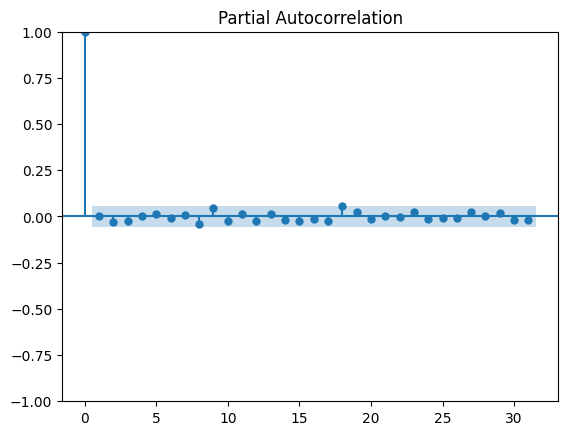

In [517]:
plot_pacf(df_apple_data_log.apple_stationary, method='ywm')
plt.show()

In [518]:


train = df_apple_data_log.iloc[:-int(len(df_apple_data_log) * 0.2)]
test = df_apple_data_log.iloc[-int(len(df_apple_data_log) * 0.2):]

selector = ar_select_order(train['apple_stationary'], 15)
model = AutoReg(train['apple_stationary'], lags=selector.ar_lags).fit()

In [556]:

transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['apple_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(df_apple_data_log['data'])

forecasts = inv_boxcox(df_apple_data_log['data']+2, lam)

In [557]:
def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Date'], y=train['data'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date'], y=test['data'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()

plot_forecasts(forecasts, 'Autoregression')

In [559]:
#Moving Average Model
model = ARIMA(train['apple_stationary'], order=(0, 0, 13)).fit()

In [566]:
transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['apple_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(df_apple_data_log['data'])

forecasts = inv_boxcox(df_apple_data_log['data']+2, lam)

In [567]:
plot_forecasts(forecasts, 'Moving Average Model')

In [571]:
#ARIMA
model = ARIMA(train['data'], order=(12, 1, 12)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [572]:
plot_forecasts(forecasts, 'ARIMA')

In [573]:
#SARIMA
# Build ARIMA model
model = ARIMA(train['data'], order=(10, 1, 10),
              seasonal_order=(1, 1, 1, 12)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

c:\Users\pc\Desktop\dev-iteso\proy-cd-entr-2\trdpyenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [574]:
plot_forecasts(forecasts, 'ARIMA')

In [ ]:
#Dynamic harmonic Fourier Series
#Failed to chargue library